In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

from astropy.io import ascii
from astropy.table import Table, Column

%matplotlib inline

In [2]:
cat = ascii.read('cat_lau.csv')

In [3]:
d010 = ascii.read('d010_resto.dat', format='ipac')
d115 = ascii.read('d115_resto.dat', format='ipac')

In [4]:
print cat.colnames

['Id', 'RAh', 'RAm', 'RAs', 'DE-', 'DEd', 'DEm', 'DEs', 'Z', 'Y', 'J', 'H', 'Ks', 'Z$_{2\\prime\\prime}$', 'Y$_{2\\prime\\prime}$', 'J$_{2\\prime\\prime}$', 'H$_{2\\prime\\prime}$', 'Ks$_{2\\prime\\prime}$', 'R$_{1/2}$', 'C', '$\\epsilon$', 'n', 'Visual']


In [5]:
gxs = cat[['J', 'H', 'Ks', 'R$_{1/2}$', 'C', '$\\epsilon$', 'n']].to_pandas()

In [6]:
strs_d010= d010[['MAG_PSF_J_C','MAG_PSF_H_C','MAG_PSF_Ks_C',
            'FLUX_RADIUS_051','C','ELLIPTICITY','SPHEROID_SERSICN']].to_pandas()

In [7]:
strs_d115= d115[['MAG_PSF_J_C','MAG_PSF_H_C','MAG_PSF_Ks_C',
                 'FLUX_RADIUS_051','C','ELLIPTICITY','SPHEROID_SERSICN']].to_pandas()

In [8]:
strs = pd.concat([strs_d010, strs_d115])

In [9]:
strs = strs[strs.MAG_PSF_J_C < 30]
gxs = gxs[gxs.J<30]

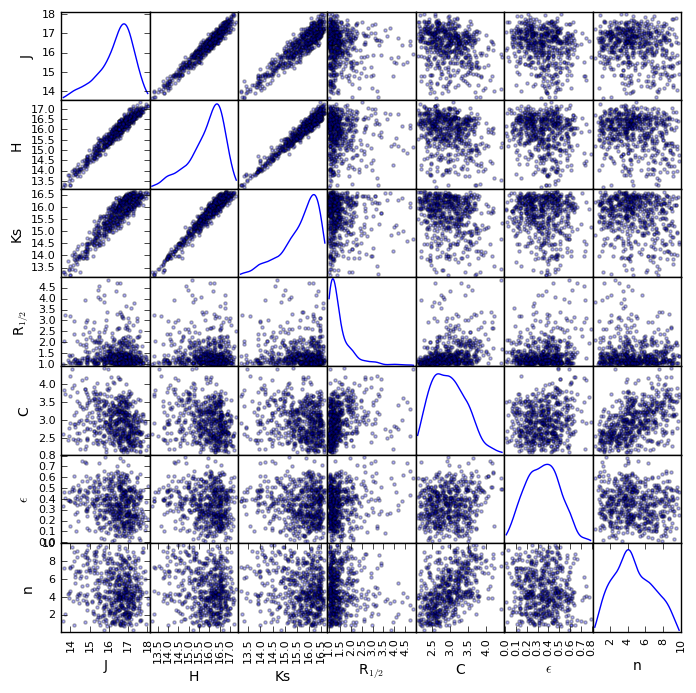

In [10]:
pd.scatter_matrix(gxs,  alpha=0.3, figsize=(8, 8), diagonal='kde')
plt.show()

In [141]:
strs = strs[(strs.MAG_PSF_J_C>12.)&(strs.MAG_PSF_H_C>12.)&(strs.MAG_PSF_Ks_C>12.)&(strs.C>0.)]
strs = strs[(strs.MAG_PSF_J_C<25.)&(strs.MAG_PSF_H_C<25.)&(strs.MAG_PSF_Ks_C<25.)&(strs.FLUX_RADIUS_051<5.)]

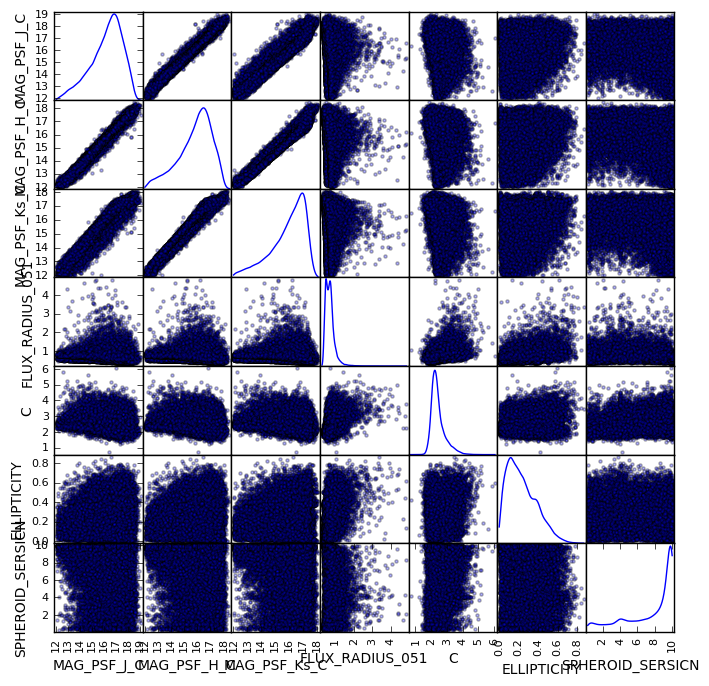

In [142]:
pd.scatter_matrix(strs,  alpha=0.3, figsize=(8, 8), diagonal='kde')
plt.show()

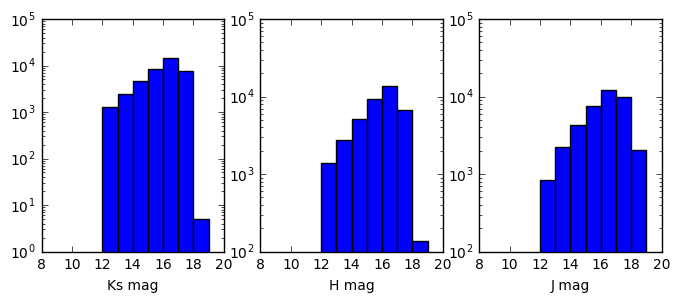

In [143]:
bins = np.arange(9, 20, 1.)

plt.figure(figsize=(8, 3))
plt.subplot(131)
plt.hist(strs['MAG_PSF_Ks_C'], log=True, bins=bins)
plt.xlabel(r'Ks mag')
plt.subplot(132)
plt.hist(strs['MAG_PSF_H_C'], log=True, bins=bins)
plt.xlabel(r'H mag')
plt.subplot(133)
plt.hist(strs['MAG_PSF_J_C'], log=True, bins=bins)
plt.xlabel(r'J mag')

plt.show()

In [144]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import neighbors
import sklearn.cross_validation as cv
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

In [145]:
def experiment(clf, x, y, nfolds=10):
    skf = StratifiedKFold(n_splits=nfolds)
    probabilities = np.array([])
    predictions = np.array([])
    y_testing = np.array([])
    
    for train, test in skf.split(x, y):
        
        x_train = x[train]
        y_train = y[train]
        clf.fit(x_train, y_train)

        x_test = x[test]
        y_test = y[test]
        pr = clf.predict(x_test)
        probs = clf.predict_proba(x_test)[:, 0]

        probabilities = np.hstack([probabilities, probs])
        predictions = np.hstack([predictions, pr])
        y_testing = np.hstack([y_testing, y_test])

    print metrics.classification_report(y_testing, predictions)
    fpr, tpr, thresholds = metrics.roc_curve(y_testing, 1.-probabilities)
    roc_auc = metrics.auc(fpr, tpr)
    return {'fpr': fpr, 
            'tpr': tpr, 
            'thresh': thresholds, 
            'roc_auc': roc_auc, 
            'y_test': y_testing, 
            'predictions': predictions,
            'probabilities': probabilities, 
            'confusion_matrix': metrics.confusion_matrix(y_testing, predictions),
            }

In [170]:
#choices = np.random.choice(40000, 2000)
strs2 = strs.sample(10000)

In [171]:
X = np.vstack((strs2.as_matrix(), gxs.as_matrix()))
Y = np.hstack((np.repeat(0, len(strs2)), np.repeat(1, len(gxs))))

In [172]:
res_Dtree = experiment(DecisionTreeClassifier(max_leaf_nodes=12), X, Y, 10)

             precision    recall  f1-score   support

        0.0       0.98      0.98      0.98     10000
        1.0       0.70      0.69      0.69       572

avg / total       0.97      0.97      0.97     10572



In [173]:
res_knn = experiment(neighbors.KNeighborsClassifier(n_neighbors=3, weights='uniform'), X, Y, 10)

             precision    recall  f1-score   support

        0.0       0.98      0.98      0.98     10000
        1.0       0.67      0.57      0.62       572

avg / total       0.96      0.96      0.96     10572



In [174]:
res_svc = experiment(svm.SVC(kernel='linear', probability=True), X, Y, 10)

             precision    recall  f1-score   support

        0.0       0.96      0.99      0.98     10000
        1.0       0.68      0.34      0.45       572

avg / total       0.95      0.96      0.95     10572



In [175]:
res_Rforest = experiment(RandomForestClassifier(n_estimators=100, min_samples_leaf=6), X, Y, 10)

             precision    recall  f1-score   support

        0.0       0.98      0.99      0.99     10000
        1.0       0.78      0.67      0.72       572

avg / total       0.97      0.97      0.97     10572



In [176]:
res_C45 = experiment(DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=12), X, Y, 10)

             precision    recall  f1-score   support

        0.0       0.99      0.98      0.98     10000
        1.0       0.72      0.75      0.73       572

avg / total       0.97      0.97      0.97     10572



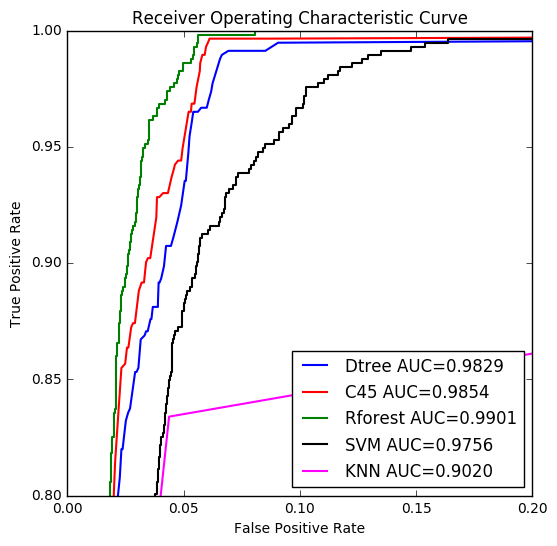

In [177]:
plt.figure(figsize=(6, 6))
#plt.figaspect(.8)

fpr = res_Dtree['fpr']
tpr = res_Dtree['tpr']
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1.5, color='blue', label='Dtree AUC={:06.4f}'.format(roc_auc))

fpr = res_C45['fpr']
tpr = res_C45['tpr']
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1.5, color='red', label='C45 AUC={:06.4f}'.format(roc_auc))

fpr = res_Rforest['fpr']
tpr = res_Rforest['tpr']
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1.5, color='green', label='Rforest AUC={:06.4f}'.format(roc_auc))

fpr = res_svc['fpr']
tpr = res_svc['tpr']
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1.5, color='black', label='SVM AUC={:06.4f}'.format(roc_auc))

fpr = res_knn['fpr']
tpr = res_knn['tpr']
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1.5, color='magenta', label='KNN AUC={:06.4f}'.format(roc_auc))

plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('Receiver Operating Characteristic Curve')

In [180]:
res_Rforest['confusion_matrix']

array([[9888,  112],
       [ 186,  386]])

## Outer Testing with all stars

In [178]:
clf = DecisionTreeClassifier(max_leaf_nodes=9, criterion='entropy')
clf.fit(X, Y)

pr = clf.predict(strs.as_matrix())
fpr = np.sum(pr)
tpr = np.sum(pr==0)
print fpr, tpr

478 38448


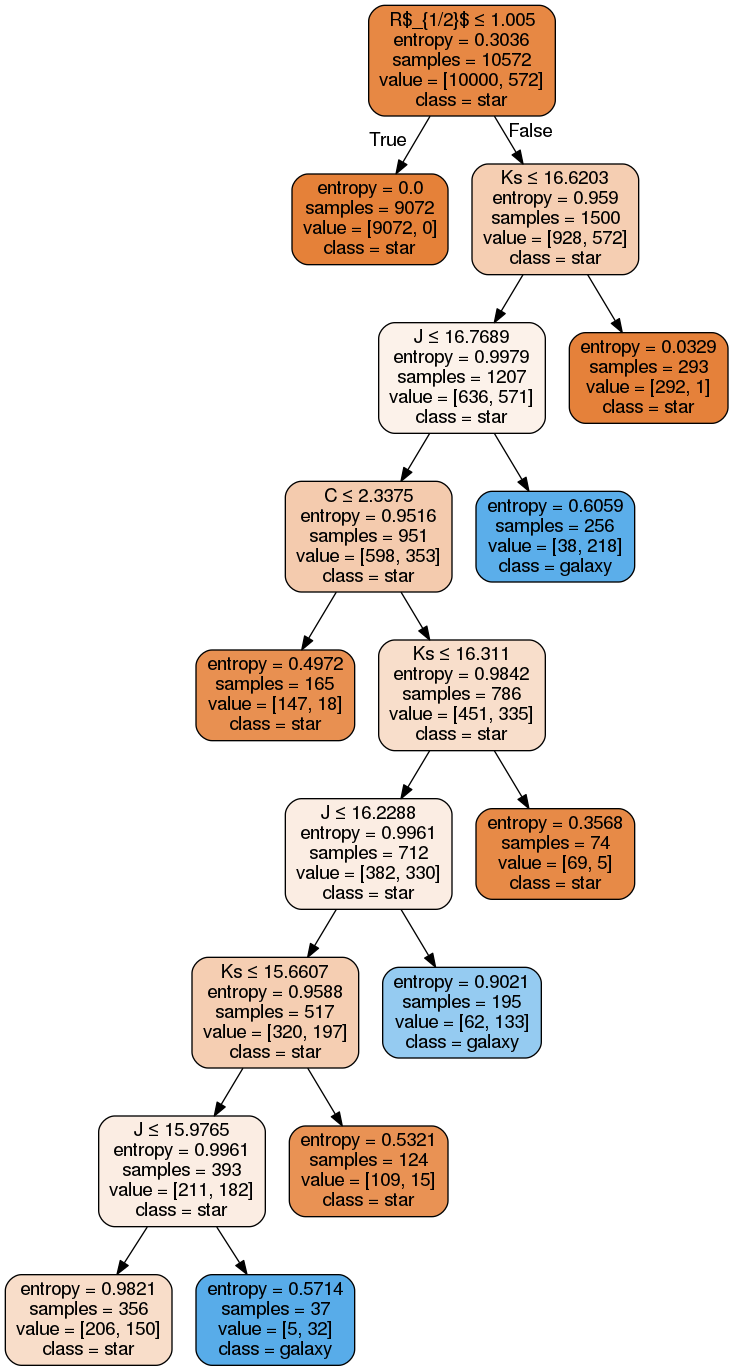

In [179]:
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=gxs.columns, 
                           class_names=['star', 'galaxy'],  
                           filled=True, 
                           rounded=True,
                           special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  